# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import estimate_market_factors as emf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-07-24"
stock_index_name = "gdaxi"

In [3]:
stock_index_list = {
    "gspc" : ["EW", "SWKS"],         # Standard and Poor's 500 - S&P 500 (United States)
    "mxx" : ["CUERVO.MX", "GCC.MX"], # Mexico Price and Quote Index (Mexico)
    "gdaxi" : ["CBK.DE", "HEN3.DE"]  # DAX Performance Index (Germany)
} 

# Define shares pair
shares_pair = stock_index_list[stock_index_name]

# Load data and filter duplicates by symbol and date
df_stock_index = pd.read_csv(
    "{}/df_stock_index_{}_{}.csv".format(
        input_path_processed,
        stock_index_name,
        re.sub("-", "", input_generation_date)
    ),
    low_memory = False
)

df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)
df_stock_index["date"] = pd.to_datetime(df_stock_index["date"], errors = "coerce")

## Entropy matrix (proof)

In [4]:
ee.estimate_entropy_pairs(
    df = df_stock_index,
    precision = 12,
    column_ = "z_score_log_return",
    log_path = log_path,
    log_filename = "log_entropy_proof_{}".format(stock_index_name),
    verbose = 1,
    entropy_args_list = (shares_pair[0], shares_pair[1], 76, 50)
)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,CBK.DE,HEN3.DE,2.829986,0.734922,3.515949,0.04896,3.466989,0.013925
1,HEN3.DE,CBK.DE,2.829986,0.734922,3.515949,0.04896,3.466989,0.013925


In [5]:
ee.estimate_entropy_matrix(
    df = df_stock_index[df_stock_index["symbol"].isin(shares_pair)],
    min_bins = 10,
    precision = 12,
    column_ = "z_score_log_return",
    log_path = log_path,
    log_filename = "log_entropy_proof_{}".format(stock_index_name),
    verbose = 1,
    tqdm_bar = True
)

100%|█████████████████████████| 3/3 [00:00<00:00,  5.03it/s]


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance
0,CBK.DE,CBK.DE,2.856032,2.856032,2.856032,2.856032,0.000000,1.00000
0,CBK.DE,HEN3.DE,2.856032,0.921448,3.706937,0.070544,3.636393,0.01903
1,HEN3.DE,CBK.DE,2.856032,0.921448,3.706937,0.070544,3.636393,0.01903
0,HEN3.DE,HEN3.DE,0.921448,0.921448,0.921448,0.921448,0.000000,1.00000


## Construct covariance matrix and compare with entropy matrix

In [6]:
if stock_index_name == "gspc":
    df_aux = df_stock_index[df_stock_index["symbol"].str.contains("(W)|(Z)")]
else:
    df_aux = df_stock_index

df_final = emf.get_market_efficiency_data_window(
    df = df_aux,
    column_ = "z_score_log_return",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_entropy_efficiency_{}".format(stock_index_name),
    log_filename_entropy = "log_entropy_proof_{}".format(stock_index_name),
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final[df_final["symbol_x"] != df_final["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 741/741 [00:10<00:00, 71.10it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
622,2015-01-01,2017-12-31,CBK.DE,HEN3.DE,2.032706,2.151406,4.011306,0.172806,3.838499,0.043080,0.956920,0.122854
623,2015-01-01,2017-12-31,HEN3.DE,CBK.DE,2.032706,2.151406,4.011306,0.172806,3.838499,0.043080,0.956920,0.122854
1118,2015-01-01,2017-12-31,HEN3.DE,ZAL.DE,2.151406,2.053317,3.983179,0.221544,3.761635,0.055620,0.944380,0.125531
1119,2015-01-01,2017-12-31,ZAL.DE,HEN3.DE,2.151406,2.053317,3.983179,0.221544,3.761635,0.055620,0.944380,0.125531
1088,2015-01-01,2017-12-31,HEN3.DE,LHA.DE,2.151406,2.470799,4.385017,0.237187,4.147830,0.054090,0.945910,0.132117
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2015-01-01,2017-12-31,DBK.DE,CBK.DE,2.032706,2.303982,3.734238,0.602451,3.131787,0.161332,0.838668,0.604932
1340,2015-01-01,2017-12-31,PAH3.DE,VOW3.DE,2.147383,2.071112,3.342390,0.876105,2.466284,0.262119,0.737881,0.863632
1341,2015-01-01,2017-12-31,VOW3.DE,PAH3.DE,2.147383,2.071112,3.342390,0.876105,2.466284,0.262119,0.737881,0.863632
944,2015-01-01,2017-12-31,EOAN.DE,RWE.DE,2.535360,2.211999,4.101830,0.645528,3.456302,0.157376,0.842624,1.153677


In [7]:
df_final_2 = emf.get_market_efficiency_data_window(
    df = df_aux,
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_entropy_efficiency_residuals_{}".format(stock_index_name),
    log_filename_entropy = "log_entropy_proof_residuals_{}".format(stock_index_name),
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-12-31")
)

df_final_2[df_final_2["symbol_x"] != df_final_2["symbol_y"]].drop_duplicates().sort_values(["correlation", "rajski_distance"], ascending = [True, True])


100%|█████████████████████| 741/741 [00:09<00:00, 75.37it/s]


,initial_date,final_date,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,rajski_distance,modified_rajski_distance,correlation
431,2015-01-01,2017-12-31,BEI.DE,DBK.DE,2.272407,2.517271,4.491537,0.298142,4.193395,0.066379,0.933621,-0.371042
432,2015-01-01,2017-12-31,DBK.DE,BEI.DE,2.272407,2.517271,4.491537,0.298142,4.193395,0.066379,0.933621,-0.371042
461,2015-01-01,2017-12-31,BEI.DE,PAH3.DE,2.272407,1.725696,3.788333,0.209770,3.578564,0.055373,0.944627,-0.341468
462,2015-01-01,2017-12-31,PAH3.DE,BEI.DE,2.272407,1.725696,3.788333,0.209770,3.578564,0.055373,0.944627,-0.341468
425,2015-01-01,2017-12-31,BEI.DE,CBK.DE,2.272407,2.122724,4.183605,0.211526,3.972079,0.050561,0.949439,-0.329782
...,...,...,...,...,...,...,...,...,...,...,...,...
515,2015-01-01,2017-12-31,MBG.DE,BMW.DE,2.603789,2.425582,4.551931,0.477440,4.074491,0.104887,0.895113,0.620488
608,2015-01-01,2017-12-31,CBK.DE,DBK.DE,2.122724,2.517271,4.180086,0.459908,3.720178,0.110024,0.889976,0.637027
609,2015-01-01,2017-12-31,DBK.DE,CBK.DE,2.122724,2.517271,4.180086,0.459908,3.720178,0.110024,0.889976,0.637027
1340,2015-01-01,2017-12-31,PAH3.DE,VOW3.DE,1.725696,1.749673,2.920661,0.554708,2.365953,0.189925,0.810075,0.881029


In [8]:
emf.get_market_efficiency(
    df = df_aux,
    column_ = "z_score_log_return",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_{}".format(stock_index_name),
    log_filename_entropy = "log_entropy_final_{}".format(stock_index_name),
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-01-01"),
    bouchaud_filter = False,
    n = int(df_aux.shape[0] * 8),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)[0]

100%|█████████████████████| 741/741 [00:09<00:00, 81.99it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_cov_mp,n_components_entropy,n_components_entropy_mp,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,4,1,1,1,8,8,3.0,8.0
1,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,4,4,1,1,1,8,8,3.0,8.0
2,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,4,4,1,1,1,8,8,3.0,8.0
3,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,4,1,1,2,8,8,3.0,8.0
4,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,4,4,1,1,2,8,8,3.0,8.0
5,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,4,4,1,1,2,8,8,3.0,8.0
6,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,4,1,1,5,8,8,3.0,8.0
7,2015-01-01,2017-01-01,z_score_log_return,0,0,0.05,4,4,1,1,5,8,8,3.0,8.0
8,2015-01-01,2017-01-01,z_score_log_return,0,0,0.10,4,4,1,1,5,8,8,3.0,8.0
9,2015-01-01,2017-01-01,z_score_log_return,0,0,0.01,4,4,1,1,10,8,8,3.0,8.0


In [9]:
emf.get_market_efficiency(
    df = df_aux,
    column_ = "z_score_zlr_no_market",
    min_bins = 10,
    precision = 12,
    log_path = log_path,
    log_filename = "log_market_efficiency_residuals_{}".format(stock_index_name),
    log_filename_entropy = "log_entropy_final_residuals_{}".format(stock_index_name),
    verbose = 1,
    tqdm_bar = True,
    market_args_list = ("2015-01-01", "2017-01-01"),
    bouchaud_filter = False,
    n = int(df_aux.shape[0] * 2),
    df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
    alphas = [0.01, 0.05, 0.10],
    k_max = 8,
    df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
    levels = [1, 2, 5, 10]
)[0]

100%|█████████████████████| 741/741 [00:09<00:00, 78.79it/s]


,initial_date,final_date,column_,dropped_eigen_cov,dropped_eigen_entropy,alpha,n_components_cov,n_components_cov_mp,n_components_entropy,n_components_entropy_mp,level,n_factors_cov,n_factors_entropy,edge_distribution_cov,edge_distribution_entropy
0,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,1,0,8,2.0,8.0
1,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.05,12,12,1,1,1,0,8,2.0,8.0
2,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.10,12,12,1,1,1,0,8,2.0,8.0
3,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,2,0,8,2.0,8.0
4,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.05,12,12,1,1,2,0,8,2.0,8.0
5,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.10,12,12,1,1,2,0,8,2.0,8.0
6,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,5,0,8,2.0,8.0
7,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.05,12,12,1,1,5,0,8,2.0,8.0
8,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.10,12,12,1,1,5,0,8,2.0,8.0
9,2015-01-01,2017-01-01,z_score_zlr_no_market,0,0,0.01,12,12,1,1,10,1,8,2.0,8.0


## Compare spectrum

In [10]:
from scipy.linalg import eigh # type: ignore

df_1 = (
    df_final[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_2 = (
    df_final[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_3 = (
    df_final[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_4 = (
    df_final_2[["symbol_x", "symbol_y", "correlation"]]
        .sort_values(["symbol_x", "symbol_y", "correlation"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "correlation")
)

df_5 = (
    df_final_2[["symbol_x", "symbol_y", "rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "rajski_distance")
)

df_6 = (
    df_final_2[["symbol_x", "symbol_y", "modified_rajski_distance"]]
        .sort_values(["symbol_x", "symbol_y", "modified_rajski_distance"], ascending = [True, True, False])
        .drop_duplicates(subset = ["symbol_x", "symbol_y"])
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_rajski_distance")
)

df_7 = pd.DataFrame(
    {
        "marchenko_pastur_upper_bound" : np.power(1 + np.sqrt(df_1.shape[0] / df_aux.shape[0]), 2),
        "eigenvalues_correlation" : eigh(df_1)[0],
        "eigenvalues_entropy" : eigh(df_2)[0],
        "eigenvalues_entropy_modified" : eigh(df_3)[0],
        "eigenvalues_correlation_res" : eigh(df_4)[0],
        "eigenvalues_entropy_res" : eigh(df_5)[0],
        "eigenvalues_entropy_modified_res" : eigh(df_6)[0]
    }
)

df_7 = df_7.reindex(index = df_7.index[::-1]).reset_index(drop = True)
df_7

,marchenko_pastur_upper_bound,eigenvalues_correlation,eigenvalues_entropy,eigenvalues_entropy_modified,eigenvalues_correlation_res,eigenvalues_entropy_res,eigenvalues_entropy_modified_res
0,1.02656,11.406322,4.023747,34.040001,4.315866,2.503666,35.514090
1,1.02656,1.769673,1.248208,-0.735834,2.699615,1.136733,-0.807957
2,1.02656,1.447050,1.098317,-0.778003,2.193181,1.058980,-0.874729
3,1.02656,0.913527,1.060300,-0.818621,2.002937,1.037053,-0.883996
4,1.02656,0.677277,1.022720,-0.829915,1.699523,1.027428,-0.894443
5,1.02656,0.575205,1.011754,-0.835514,1.518733,1.010700,-0.902437
6,1.02656,0.537512,0.981434,-0.842923,1.441720,0.999890,-0.911096
7,1.02656,0.522411,0.976459,-0.844413,1.302809,0.997224,-0.913240
8,1.02656,0.486873,0.969884,-0.850622,1.236907,0.992453,-0.919385
9,1.02656,0.446399,0.953918,-0.854898,1.170520,0.986001,-0.932717


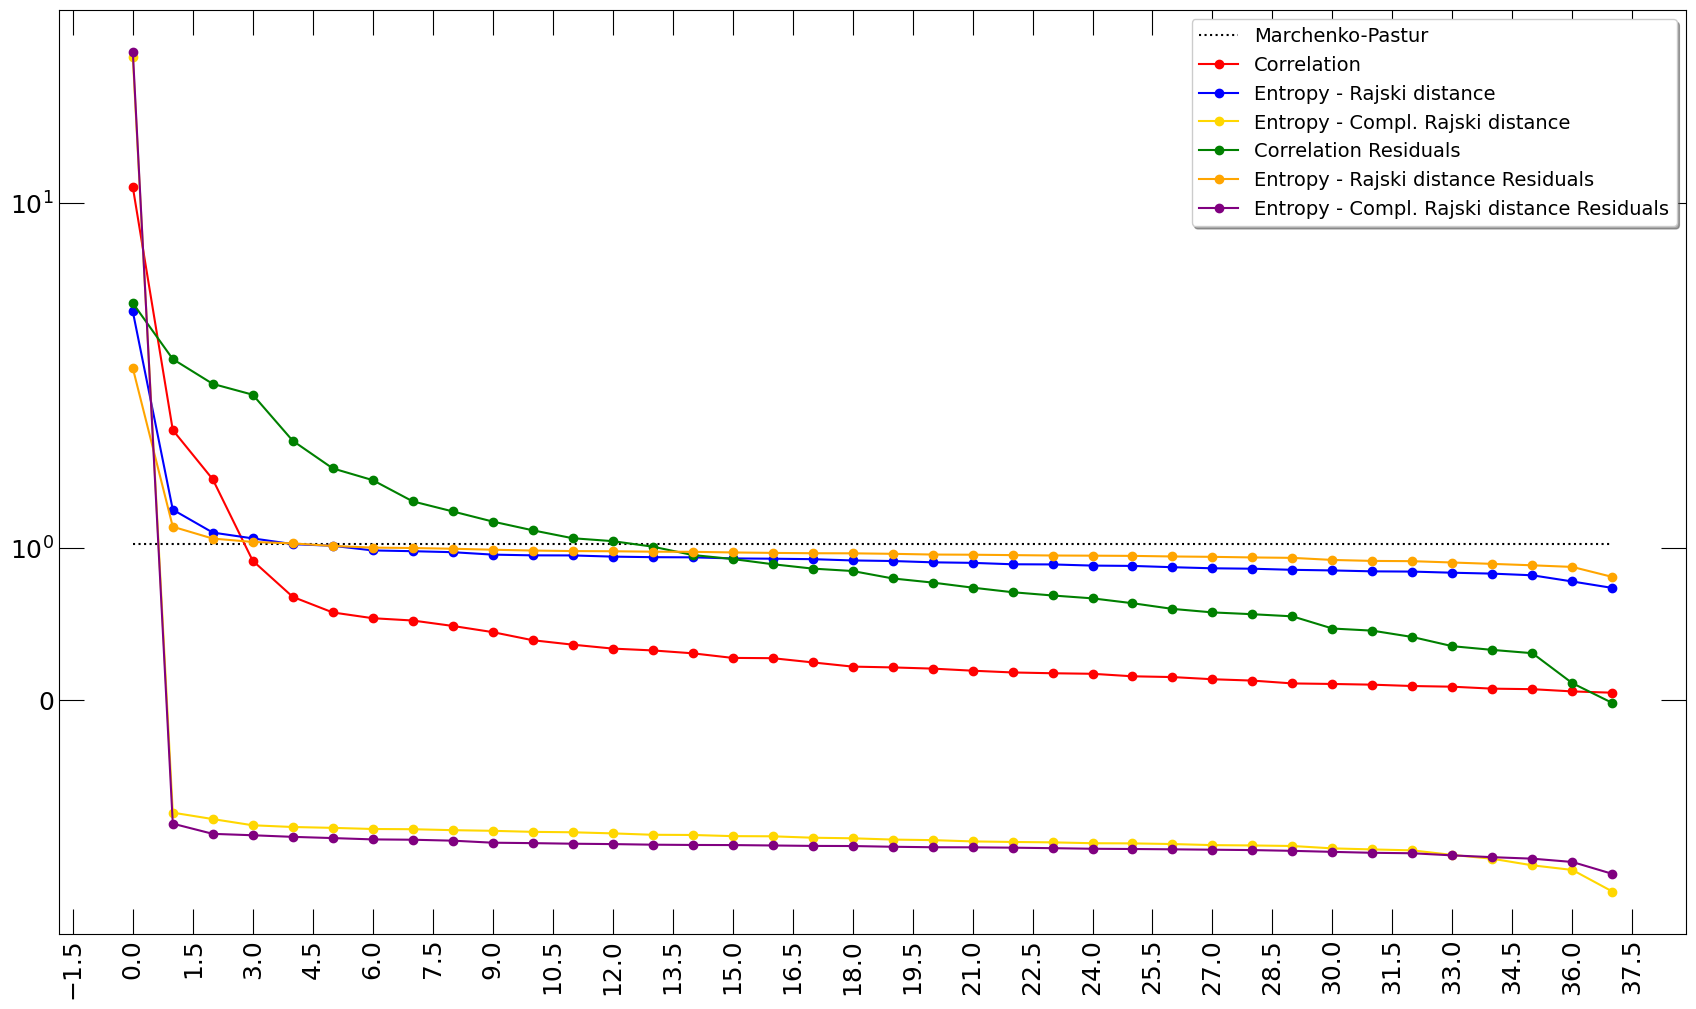

In [11]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 12)

df_8 = df_7#.tail(5)

ax.plot(df_8["marchenko_pastur_upper_bound"], color = "black", marker = "", linestyle = "dotted", label = "Marchenko-Pastur")
ax.plot(df_8["eigenvalues_correlation"], color = "red", marker = "o", label = "Correlation")
ax.plot(df_8["eigenvalues_entropy"], color = "blue", marker = "o", label = "Entropy - Rajski distance")
ax.plot(df_8["eigenvalues_entropy_modified"], color = "gold", marker = "o", label = "Entropy - Compl. Rajski distance")
ax.plot(df_8["eigenvalues_correlation_res"], color = "green", marker = "o", label = "Correlation Residuals")
ax.plot(df_8["eigenvalues_entropy_res"], color = "orange", marker = "o", label = "Entropy - Rajski distance Residuals")
ax.plot(df_8["eigenvalues_entropy_modified_res"], color = "purple", marker = "o", label = "Entropy - Compl. Rajski distance Residuals")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 18, length = 18)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 18, length = 10)
ax.xaxis.set_major_locator(mtick.MaxNLocator(df_5.shape[0]))
ax.yaxis.set_major_locator(mtick.MaxNLocator(40))
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend(fancybox = True, shadow = True, ncol = 1, fontsize = 14)

#ax.set_xscale(value = "log")
ax.set_yscale(value = "symlog")

plt.show()


## Exploratory Data Analysis

symbol       date    CBK.DE   HEN3.DE    temp_1    temp_2  mask
0      2000-01-04  0.000000  0.000000  0.000000  0.000000     1
1      2000-01-05 -0.953624  0.139672 -0.953624  0.139672     0
2      2000-01-06  0.504810 -1.704803  0.504810 -1.704803     1
3      2000-01-07  1.114079  0.851497  1.114079  0.851497     1
4      2000-01-10 -0.058856  0.591840 -0.058856  0.591840     0


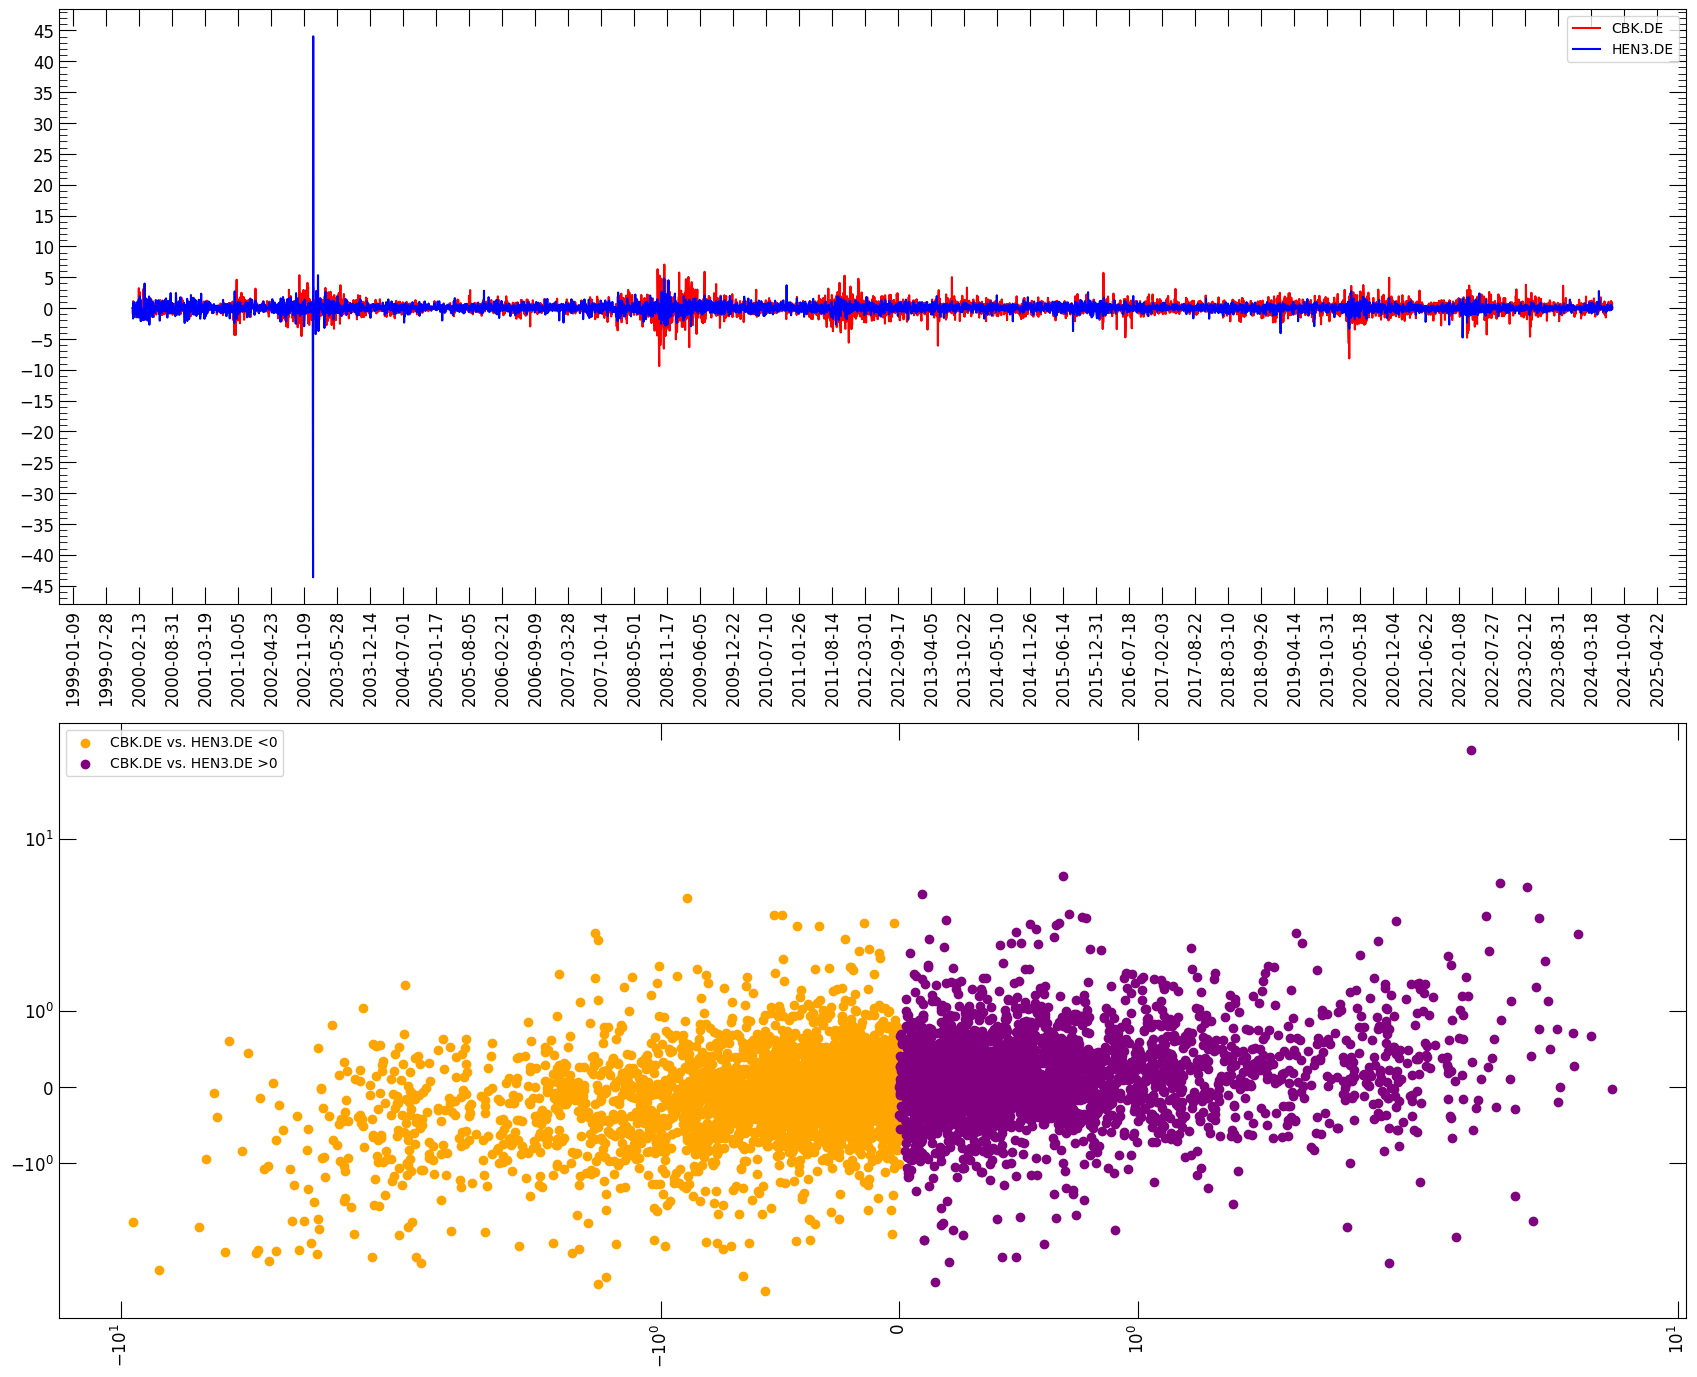

In [12]:
column_ = "z_score_log_return"

import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == shares_pair[0]]
df_2 = df_stock_index[df_stock_index["symbol"] == shares_pair[1]]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin(shares_pair)]
        .pivot(index = "date", columns = "symbol", values = column_)
        .reset_index()
)
df_3["temp_1"] = df_3[shares_pair[0]]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[shares_pair[1]]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[shares_pair[0]] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1[column_], color = "red", label = shares_pair[0])
ax[0].plot(df_2["date"], df_2[column_], color = "blue", label = shares_pair[1])
ax[1].scatter(
    df_3[df_3["mask"] == 0]["temp_1"],
    df_3[df_3["mask"] == 0]["temp_2"],
    color = "orange",
    label = "{} vs. {} <0".format(shares_pair[0], shares_pair[1])
)
ax[1].scatter(
    df_3[df_3["mask"] == 1]["temp_1"],
    df_3[df_3["mask"] == 1]["temp_2"],
    color = "purple",
    label = "{} vs. {} >0".format(shares_pair[0], shares_pair[1])
)

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()
